In [201]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import HistGradientBoostingRegressor # faster than GradientBoostingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [202]:
data = pd.read_csv('../data/data_2010_2021.csv', parse_dates=['Date']).set_index('Date')
data = data[data.index>='2020-01-01']
data['date'] = data.index
data = data[~data.stock_closing_usd.isna()]
print(data.shape)
print(data.isnull().sum().sort_values(0, ascending=False))
data.head(2)

(285, 37)
LONG-TERM INTEREST RATES_RUSSIA                                       285
SHORT-TERM INTEREST RATES_CHINA                                       285
jodi_demand                                                           280
SHORT-TERM INTEREST RATES_RUSSIA                                      279
SHORT-TERM INTEREST RATES_UNITED STATES                               278
LONG-TERM INTEREST RATES_EURO AREA(19 COUNTRIES)                      277
LONG-TERM INTEREST RATES_INDIA                                        277
LONG-TERM INTEREST RATES_UNITED STATES                                277
SHORT-TERM INTEREST RATES_EURO AREA(19 COUNTRIES)                     277
SHORT-TERM INTEREST RATES_INDIA                                       277
OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY      275
IMPORTED  CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL                275
CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD    275
CRUDE OIL AND LIQUID FUELS S

,stock_closing_usd,sentiment_global_index,sentiment_finance_index,DOW JONES COMPOSITE AVERAGE,DOW JONES INDUSTRIAL AVERAGE,DOW JONES TRANSPORTATION AVERAGE,DOW JONES UTILITY AVERAGE,S&P 500,ICE BRENT CRUDE OIL FUTURES,NYMEX CRUDE OIL FUTURES,...,DRIVING,TRANSIT,WALKING,GROCERY AND PHARMACY PERCENT CHANGE FROM BASELINE,PARKS PERCENT CHANGE FROM BASELINE,RESIDENTIAL PERCENT CHANGE FROM BASELINE,RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE,TRANSIT STATIONS PERCENT CHANGE FROM BASELINE,WORKPLACES PERCENT CHANGE FROM BASELINE,date
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,70.90,NaN,NaN,9446.78,28868.80,10994.31,866.82,3257.85,66.25,61.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-02
2020-01-03,70.33,NaN,NaN,9385.56,28634.88,10911.40,867.44,3234.85,68.60,63.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-03


In [203]:
# feature = data.isnull().sum().sort_values(0, ascending=False).tail(141).index.to_list()
basic_feature = ['date','stock_closing_usd']
# mobility_feature = ['TRANSIT STATIONS PERCENT CHANGE FROM BASELINE','RESIDENTIAL PERCENT CHANGE FROM BASELINE','PARKS PERCENT CHANGE FROM BASELINE','GROCERY AND PHARMACY PERCENT CHANGE FROM BASELINE','WORKPLACES PERCENT CHANGE FROM BASELINE','RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE','DRIVING', 'TRANSIT', 'WALKING']
mobility_feature = ['RESIDENTIAL PERCENT CHANGE FROM BASELINE','RETAIL AND RECREATION PERECENT CHANGE FROM BASELINE','DRIVING']
commodity_feature = ['NYMEX CRUDE OIL FUTURES', 'ICE BRENT CRUDE OIL FUTURES','NYMEX RBOB GASOLINE FUTURES']
outlook_feature = ['CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY','CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD','IMPORTED  CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL','OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY','U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY']
demand_feature = ['jodi_demand']

feature_to_shift = commodity_feature + outlook_feature + demand_feature
feature = basic_feature + feature_to_shift

print(feature)

data_subset = data[feature].sort_values('date')
print(data_subset.shape)
data_subset.head(2)

['date', 'stock_closing_usd', 'NYMEX CRUDE OIL FUTURES', 'ICE BRENT CRUDE OIL FUTURES', 'NYMEX RBOB GASOLINE FUTURES', 'CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY', 'CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD', 'IMPORTED  CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL', 'OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY', 'U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY', 'jodi_demand']
(285, 11)


,date,stock_closing_usd,NYMEX CRUDE OIL FUTURES,ICE BRENT CRUDE OIL FUTURES,NYMEX RBOB GASOLINE FUTURES,CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY,"CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD",IMPORTED CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL,OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY,U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY,jodi_demand
Date,,,,,,,,,,,
2020-01-02,2020-01-02,70.90,61.18,66.25,1.70,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,2020-01-03,70.33,63.05,68.60,1.75,NaN,NaN,NaN,NaN,NaN,NaN


In [204]:
if len(set(data_subset.columns) & set(outlook_feature))>0:
    for feature in set(data_subset.columns) & set(outlook_feature):
        print('Filling backward for ', feature)
        data_subset[feature] = data_subset[feature].bfill()

Filling backward for  OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY
Filling backward for  CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD
Filling backward for  IMPORTED  CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL
Filling backward for  U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY
Filling backward for  CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY


In [205]:
data_subset_feature = data_subset[feature_to_shift].shift(1)
data_subset = pd.merge(data_subset['stock_closing_usd'],data_subset_feature,left_index=True, right_index=True)

# data_subset_7 = data_subset.shift(7)
# data_subset_30 = data_subset.shift(30)
# data_subset = pd.merge(data_subset_7, data_subset_30, suffixes=['_7','_30'], left_index=True, right_index=True)

# feature engineering
# data_subset['workplaces_percent_changes'] = data_subset['WORKPLACES PERCENT CHANGE FROM BASELINE'].diff()
# data_subset['driving_changes'] = data_subset['DRIVING'].diff()

print(data_subset.shape)
data_subset.head(5)

(285, 10)


,stock_closing_usd,NYMEX CRUDE OIL FUTURES,ICE BRENT CRUDE OIL FUTURES,NYMEX RBOB GASOLINE FUTURES,CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY,"CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD",IMPORTED CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL,OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY,U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY,jodi_demand
Date,,,,,,,,,,
2020-01-02,70.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,70.33,61.18,66.25,1.70,20.1,485.99,52.39,33.19,12.46,NaN
2020-01-06,70.87,63.05,68.60,1.75,20.1,485.99,52.39,33.19,12.46,NaN
2020-01-07,70.29,63.27,68.91,1.75,20.1,485.99,52.39,33.19,12.46,NaN
2020-01-08,69.23,62.70,68.27,1.72,20.1,485.99,52.39,33.19,12.46,NaN


In [206]:
# backward fill jodi demand monthly data
data_subset['jodi_demand'] = data_subset['jodi_demand'].bfill()
# data_subset.isnull().sum()
# data_subset[data_subset.Date>'2020-02-27'].head(15)

# # drop na
data_subset = data_subset.dropna()

print(data_subset.shape)
data_subset.head(2)

(111, 10)


,stock_closing_usd,NYMEX CRUDE OIL FUTURES,ICE BRENT CRUDE OIL FUTURES,NYMEX RBOB GASOLINE FUTURES,CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY,"CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD",IMPORTED CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL,OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY,U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY,jodi_demand
Date,,,,,,,,,,
2020-01-03,70.33,61.18,66.25,1.70,20.1,485.99,52.39,33.19,12.46,72545.42
2020-01-06,70.87,63.05,68.60,1.75,20.1,485.99,52.39,33.19,12.46,72545.42


In [207]:
data_subset.describe()

,stock_closing_usd,NYMEX CRUDE OIL FUTURES,ICE BRENT CRUDE OIL FUTURES,NYMEX RBOB GASOLINE FUTURES,CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY,"CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD",IMPORTED CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL,OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY,U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY,jodi_demand
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,51.204324,38.483153,43.465045,1.196667,20.516757,503.069820,52.615946,33.210090,12.665225,67587.189009
std,10.205269,15.650419,14.115492,0.364648,0.296982,10.068587,0.319751,0.019376,0.134251,4094.773773
min,32.740000,-37.630000,19.330000,0.410000,20.100000,485.990000,52.180000,33.180000,12.460000,62145.540000
25%,44.100000,27.255000,30.970000,0.920000,20.220000,498.550000,52.290000,33.190000,12.550000,63413.350000
50%,47.140000,38.720000,41.050000,1.200000,20.620000,505.660000,52.870000,33.220000,12.730000,67418.260000
75%,60.435000,51.295000,56.045000,1.525000,20.830000,509.980000,52.870000,33.230000,12.800000,72545.420000
max,70.870000,63.270000,68.910000,1.750000,20.830000,516.460000,53.060000,33.230000,12.810000,72545.420000


In [208]:
data_subset.columns

Index(['stock_closing_usd', 'NYMEX CRUDE OIL FUTURES',
       'ICE BRENT CRUDE OIL FUTURES', 'NYMEX RBOB GASOLINE FUTURES',
       'CRUDE OIL AND LIQUID FUELS SUPPLY_MILLION BARRELS PER DAY',
       'CRUDE OIL INVENTORY (EXCLUDING SPR)_MILLION BARRELS, END-OF-PERIOD',
       'IMPORTED  CRUDE OIL REAL PRICE_REAL DOLLARS PER BARREL',
       'OPEC TOTAL CRUDE OIL PRODUCTION CAPACITY_MILLION BARRELS PER DAY',
       'U.S. CRUDE OIL PRODUCTION_MILLION BARRELS PER DAY', 'jodi_demand'],
      dtype='object')

In [209]:
# normalize variables
# X = preprocessing.normalize(data_subset[mobility_feature])
# X

In [210]:
X = data_subset.drop(columns=['stock_closing_usd'])
# X = data_subset.drop(columns=['date_7','date_30','stock_closing_usd_7','stock_closing_usd_30'])

In [189]:
y = data_subset['stock_closing_usd']
y

Date
2020-01-03    70.33
2020-01-06    70.87
2020-01-07    70.29
2020-01-08    69.23
2020-01-09    69.76
2020-01-10    69.14
2020-01-13    69.80
2020-01-14    69.20
2020-01-15    69.09
2020-01-16    68.82
2020-01-17    68.56
2020-01-21    67.58
2020-01-22    67.19
2020-01-23    66.77
2020-01-24    66.32
2020-01-27    64.74
2020-01-28    64.65
2020-01-29    64.11
2020-01-30    64.79
2020-01-31    62.12
2020-02-03    60.73
2020-02-04    59.97
2020-02-05    62.73
2020-02-06    61.88
2020-02-07    61.47
2020-02-10    59.96
2020-02-11    60.53
2020-02-12    61.27
2020-02-13    60.93
2020-02-14    60.65
              ...  
2020-05-21    44.56
2020-05-22    44.60
2020-05-26    45.91
2020-05-27    46.24
2020-05-28    45.04
2020-05-29    45.47
2020-06-01    46.28
2020-06-02    47.31
2020-06-03    49.24
2020-06-04    49.10
2020-06-05    53.08
2020-06-08    54.74
2020-06-09    53.52
2020-06-10    50.65
2020-06-11    46.18
2020-06-12    47.17
2020-06-15    47.14
2020-06-16    48.20
2020-06-17    4

In [190]:
data_subset.shape

(111, 10)

In [191]:
# sample_data = pd.read_csv('..\sample_dataset\sample_data.csv')
# data = sample_data.copy()
# X = data[['Daily News Sentiment','Value'
# y = data[['Value']

In [192]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(88, 9) (23, 9) (88,) (23,)


In [193]:
y_train

Date
2020-01-03    70.33
2020-01-06    70.87
2020-01-07    70.29
2020-01-08    69.23
2020-01-09    69.76
2020-01-10    69.14
2020-01-13    69.80
2020-01-14    69.20
2020-01-15    69.09
2020-01-16    68.82
2020-01-17    68.56
2020-01-21    67.58
2020-01-22    67.19
2020-01-23    66.77
2020-01-24    66.32
2020-01-27    64.74
2020-01-28    64.65
2020-01-29    64.11
2020-01-30    64.79
2020-01-31    62.12
2020-02-03    60.73
2020-02-04    59.97
2020-02-05    62.73
2020-02-06    61.88
2020-02-07    61.47
2020-02-10    59.96
2020-02-11    60.53
2020-02-12    61.27
2020-02-13    60.93
2020-02-14    60.65
              ...  
2020-04-20    41.18
2020-04-21    40.96
2020-04-22    42.13
2020-04-23    43.45
2020-04-24    43.73
2020-04-27    43.94
2020-04-28    44.97
2020-04-29    47.46
2020-04-30    46.47
2020-05-01    43.14
2020-05-04    44.88
2020-05-05    44.83
2020-05-06    43.99
2020-05-07    44.24
2020-05-08    46.18
2020-05-11    45.74
2020-05-12    44.12
2020-05-13    41.93
2020-05-14    4

In [194]:
model_dict = {
    'LR': LinearRegression(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'GB': GradientBoostingRegressor(),
    'HGB': HistGradientBoostingRegressor(),
    'XGB': XGBRegressor(),
    # 'LGBM': LGBMRegressor(),
    'CB': CatBoostRegressor(verbose=0),
    'SVR': SVR(C=1.0, epsilon=0.2),
    'LSVR': LinearSVR(random_state=0, tol=1e-5),
    'SGD': SGDRegressor(max_iter=1000, tol=1e-3)}

In [195]:
model_performance = pd.DataFrame(columns=['model','r2','mse'])

for model_name in model_dict.values():

    model = model_name.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = model.score(X, y)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**(1/2)

    print('***************************************************\n',model_name)
    print('R2: ',r2)
    print('MSE: ',mse)
    print('MSE: ',rmse)

    performance = pd.DataFrame(np.array([[model_name, r2, mse, rmse]]), columns=['model','r2','mse','rmse'])
    model_performance = model_performance.append(performance)

model_performance = model_performance.reset_index(drop=True)

***************************************************
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
R2:  0.9286148293482606
MSE:  11.595892601378377
MSE:  3.405274232918456
***************************************************
 DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')
R2:  0.9245794954314716
MSE:  37.566713043478295
MSE:  6.129169033684606
***************************************************
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_sam

In [196]:
model_performance

,model,mse,r2,rmse
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",11.5959,0.928615,3.40527
1,"DecisionTreeRegressor(criterion='mse', max_dep...",37.5667,0.924579,6.12917
2,"(DecisionTreeRegressor(criterion='mse', max_de...",14.5004,0.964596,3.80793
3,([DecisionTreeRegressor(criterion='friedman_ms...,13.1315,0.972338,3.62375
4,HistGradientBoostingRegressor(l2_regularizatio...,16.6067,0.941161,4.07513
5,"XGBRegressor(base_score=0.5, booster='gbtree',...",12.8729,0.974156,3.58789
6,<catboost.core.CatBoostRegressor object at 0x0...,11.5416,0.975117,3.3973
7,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...",13.3018,0.549245,3.64716
8,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i...",43.24,-0.0749499,6.57571
9,"SGDRegressor(alpha=0.0001, average=False, earl...",1.16077e+35,-1.27561e+33,3.40701e+17


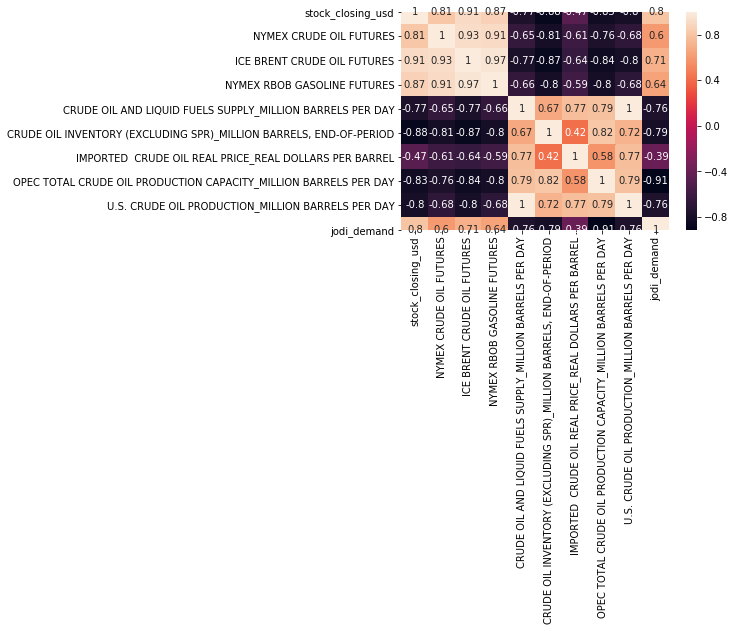

In [197]:
# combined_data_corr = pd.DataFrame(combined_data)

corrMatrix = data_subset.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

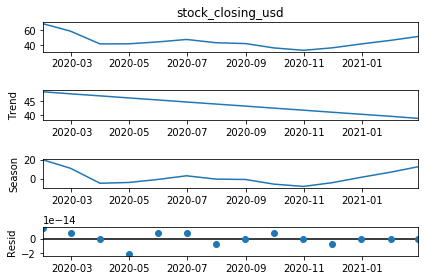

In [199]:
from statsmodels.tsa.seasonal import STL

series = data['stock_closing_usd'].resample('M').mean()

result = STL(series).fit()
chart = result.plot()
plt.show()

## Graveyard

In [176]:
# LR = LinearRegression().fit(X_train, y_train)
# DT = DecisionTreeRegressor().fit(X_train, y_train)
# RF = RandomForestRegressor().fit(X_train, y_train)
# GB = GradientBoostingRegressor().fit(X_train, y_train)
# HGB = HistGradientBoostingRegressor().fit(X_train, y_train)
# XGB = XGBRegressor().fit(X_train, y_train)
# LGBM = LGBMRegressor().fit(X_train, y_train)
# CB = CatBoostRegressor().fit(X_train, y_train)

In [135]:
# # return R2
# LR.score(X, y)
# DT.score(X, y)
# RF.score(X, y)
# GB.score(X,y)
# HGB.score(X,y)
# XGB.score(X,y)
# LGBM.score(X,y)
# CB.score(X,y)

In [136]:
# y_pred = LR.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = DT.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = RF.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = GB.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = HGB.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = XGB.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = LGBM.predict(X_test)
# mean_squared_error(y_test, y_pred)

# y_pred = CB.predict(X_test)
# mean_squared_error(y_test, y_pred)

In [137]:
# import numpy as np
# pd.DataFrame(np.array([y_test.transpose(), y_pred.transpose()]))